2025-08-27 08:42:54.178944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 08:42:54.246660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 08:42:56.160173: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Original Tax Revenue Data:
        Date  Tax_Revenue
0 2020-01-01     0.745071
1 2020-01-02     1.439284
2 2020-01-03     4.113203
3 2020-01-04     6.632701
4 2020-01-05     4.806393
5 2020-01-06     5.149289
6 2020-01-07     7.721779
7 2020-01-08     5.890458
8 2020-01-09     3.025330
9 2020-01-10     3.246361

Data series length: 1000


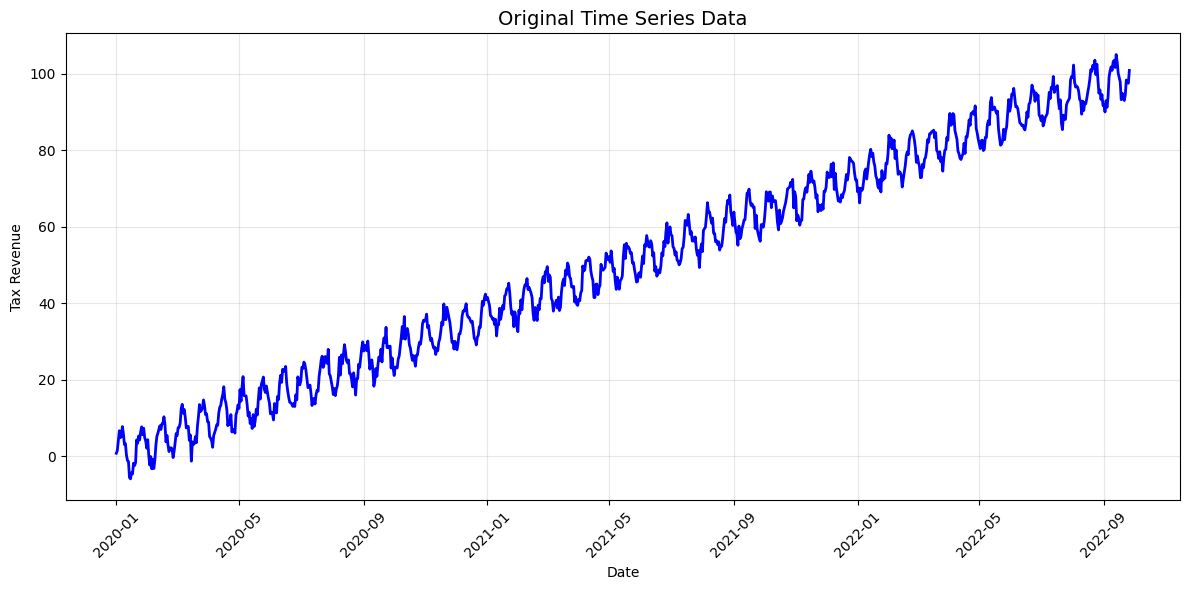

数据统计信息:
均值: 50.0290
标准差: 29.1442
最小值: -5.9480
最大值: 105.0109


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子以确保结果可重现
np.random.seed(42)
tf.random.set_seed(42)

# 创建模拟时间序列数据
years = pd.date_range(start='2020-01-01', periods=1000, freq='D')
trend = np.linspace(0, 100, 1000)
seasonality = 5 * np.sin(np.linspace(0, 100*np.pi, 1000))
noise = np.random.randn(1000) * 1.5
tax_revenue = trend + seasonality + noise

data = pd.DataFrame({
    'Date': years,
    'Tax_Revenue': tax_revenue
})

print("Original Tax Revenue Data:")
print(data.head(10))
print(f"\nData series length: {len(tax_revenue)}")

# 可视化原始数据
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Tax_Revenue'], 'b-', linewidth=2)
plt.title('Original Time Series Data', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Tax Revenue')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"数据统计信息:")
print(f"均值: {np.mean(tax_revenue):.4f}")
print(f"标准差: {np.std(tax_revenue):.4f}")
print(f"最小值: {np.min(tax_revenue):.4f}")
print(f"最大值: {np.max(tax_revenue):.4f}")

In [8]:
# 数据预处理
def create_sequences(data, time_steps=100):
    """
    创建用于LSTM训练的序列数据
    
    参数:
    data: 一维数组，时间序列数据
    time_steps: 时间窗口大小，用过去time_steps个时间点预测下一个时间点
    
    返回:
    X: 特征序列 (samples, time_steps, features)
    y: 目标值 (samples,)
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tax_revenue.reshape(-1, 1)).flatten()

print("数据预处理:")
print(f"原始数据范围: [{np.min(tax_revenue):.4f}, {np.max(tax_revenue):.4f}]")
print(f"标准化后范围: [{np.min(scaled_data):.4f}, {np.max(scaled_data):.4f}]")

# 设置时间窗口大小
time_steps = 100
print(f"时间窗口大小: {time_steps}")
print(scaled_data)

# 创建序列数据
X, y = create_sequences(scaled_data, time_steps)
print(f"序列数据形状: X={X.shape}, y={y.shape}")

# 数据分割：训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"训练集大小: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"测试集大小: X_test={X_test.shape}, y_test={y_test.shape}")

# 重新调整数据形状以适应LSTM输入要求 (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"重新调整后的形状:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

数据预处理:
原始数据范围: [-5.9480, 105.0109]
标准化后范围: [0.0000, 1.0000]
时间窗口大小: 100
[0.06032042 0.0665769  0.09067519 0.11338178 0.09692246 0.10001276
 0.12319693 0.10669244 0.0808709  0.08286291 0.05622051 0.04316009
 0.04107818 0.00290494 0.         0.01447509 0.01156213 0.03687647
 0.03128905 0.03798539 0.09174513 0.08370585 0.10110367 0.09174057
 0.11085775 0.12271885 0.10424238 0.11927166 0.09691026 0.08935771
 0.07211038 0.09226991 0.05543935 0.03234879 0.05239513 0.02361735
 0.04621016 0.02434773 0.04388257 0.07805199 0.10024084 0.10738607
 0.11689774 0.12513752 0.116357   0.12952773 0.13152707 0.14635701
 0.1274867  0.08723942 0.10238505 0.07979846 0.0642865  0.07279571
 0.07317202 0.07075764 0.05017586 0.06487218 0.08459038 0.10689224
 0.10210626 0.12087043 0.12177439 0.13124253 0.1654543  0.17563116
 0.15473118 0.16350463 0.14554072 0.12012367 0.12064882 0.12357111
 0.09076992 0.10355914 0.04177995 0.08732754 0.08083348 0.08322425
 0.0996282  0.08514944 0.12394043 0.14651816 0.17497754 0

In [3]:
# 构建LSTM模型
def build_lstm_model(input_shape, units=[50, 50], dropout_rate=0.2):
    """
    构建LSTM模型
    
    参数:
    input_shape: 输入数据形状 (time_steps, features)
    units: 每层LSTM的神经元数量
    dropout_rate: Dropout比率，防止过拟合
    
    返回:
    model: 编译好的Keras模型
    """
    model = Sequential()
    
    # 第一层LSTM
    model.add(LSTM(units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # 第二层LSTM
    model.add(LSTM(units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # 输出层
    model.add(Dense(1))
    
    # 编译模型
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# 创建模型
input_shape = (time_steps, 1)
model = build_lstm_model(input_shape, units=[50, 50], dropout_rate=0.2)

print("LSTM模型结构:")
model.summary()

# 训练模型
print("\n开始训练LSTM模型...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False  # 时间序列数据不建议打乱顺序
)

print("模型训练完成！")

LSTM模型结构:


2025-08-27 08:43:30.071067: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


开始训练LSTM模型...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0055 - mae: 0.0596 - val_loss: 0.0019 - val_mae: 0.0367
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0065 - mae: 0.0658 - val_loss: 0.0022 - val_mae: 0.0388
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0049 - mae: 0.0575 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0061 - mae: 0.0638 - val_loss: 0.0064 - val_mae: 0.0698
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0056 - mae: 0.0594 - val_loss: 0.0035 - val_mae: 0.0494
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0053 - mae: 0.0594 - val_loss: 0.0030 - val_mae: 0.0448
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0043 - mae: 0.0533 - val_loss: 0.0039 - val_mae: 0.0526
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0037 - mae: 0.0487 - val_loss: 0.0030 - val_mae: 0.0454
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s

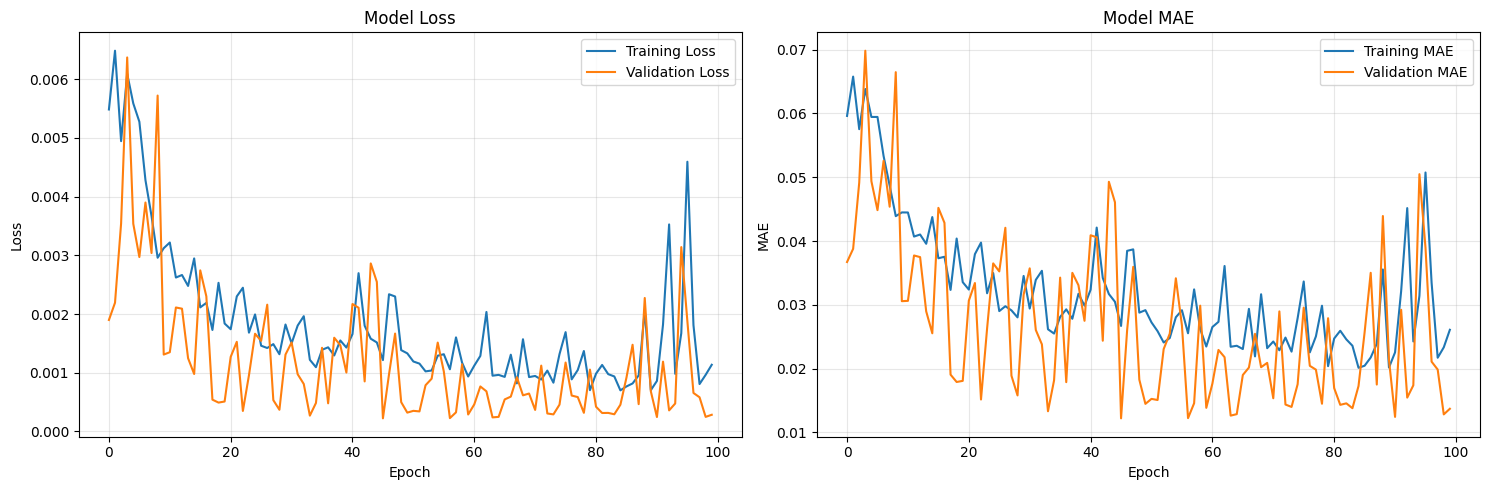

进行模型预测...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

模型评估结果:
训练集 - MSE: 11.2029, MAE: 2.7590
测试集 - MSE: 3.4960, MAE: 1.5223
训练集 - RMSE: 3.3471
测试集 - RMSE: 1.8698
训练集 - R2: 0.9747
测试集 - R2: 0.9088


In [4]:
from sklearn.metrics import r2_score

# 绘制训练历史
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 模型预测
print("进行模型预测...")
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# 反标准化预测结果
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 计算评估指标
train_mse = mean_squared_error(y_train_actual, train_predictions)
test_mse = mean_squared_error(y_test_actual, test_predictions)
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

print(f"\n模型评估结果:")
print(f"训练集 - MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
print(f"测试集 - MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")
print(f"训练集 - RMSE: {np.sqrt(train_mse):.4f}")
print(f"测试集 - RMSE: {np.sqrt(test_mse):.4f}")

# 计算 R2 得分
train_r2 = r2_score(y_train_actual, train_predictions)
test_r2 = r2_score(y_test_actual, test_predictions)
print(f"训练集 - R2: {train_r2:.4f}")
print(f"测试集 - R2: {test_r2:.4f}")

# # 准备绘图数据
# train_plot = np.empty_like(scaled_data)
# train_plot[:] = np.nan
# train_plot[time_steps:len(train_predictions)+time_steps] = train_predictions.flatten()

# test_plot = np.empty_like(scaled_data)
# test_plot[:] = np.nan
# test_plot[len(train_predictions)+(time_steps):len(scaled_data)] = test_predictions.flatten()

# # 绘制预测结果
# plt.figure(figsize=(15, 8))
# plt.plot(data['Date'], tax_revenue, label='Actual Data', linewidth=2, color='blue')
# plt.plot(data['Date'], scaler.inverse_transform(train_plot.reshape(-1, 1)).flatten(), 
#          label='Training Predictions', linewidth=2, color='green', alpha=0.7)
# plt.plot(data['Date'], scaler.inverse_transform(test_plot.reshape(-1, 1)).flatten(), 
#          label='Test Predictions', linewidth=2, color='red', alpha=0.7)

# plt.title('LSTM Model Predictions vs Actual Data', fontsize=16)
# plt.xlabel('Date')
# plt.ylabel('Tax Revenue')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# print("模型预测可视化完成！")

使用最后100个数据点预测未来20个时间步...


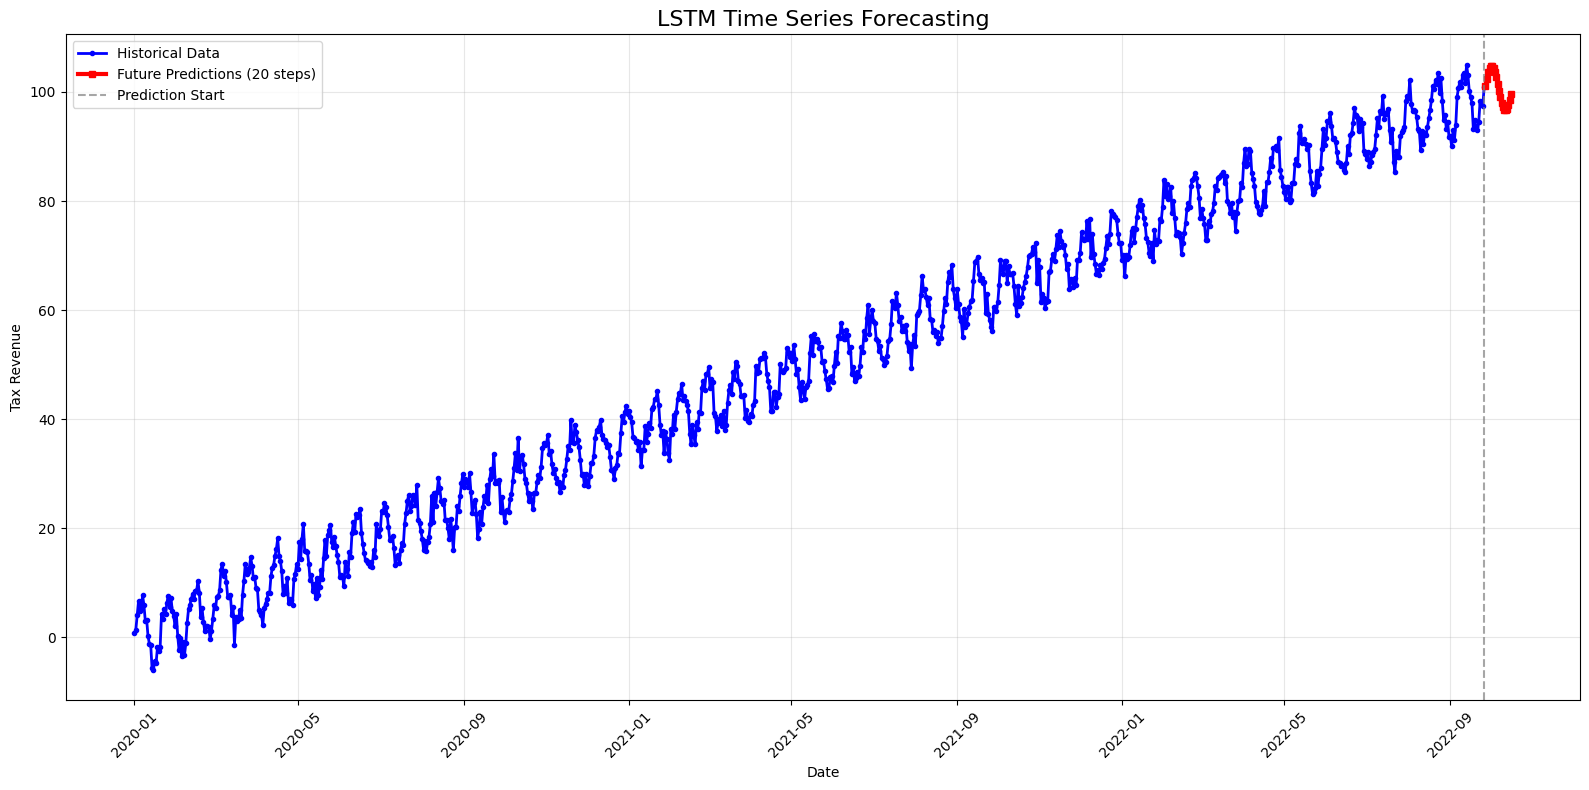


未来预测统计分析:
预测均值: 100.6868
预测标准差: 2.9293
预测最小值: 96.6268
预测最大值: 104.8103

与历史数据比较:
历史数据均值: 50.0290
历史数据标准差: 29.1442

趋势分析:
最近10天平均值: 96.1543
未来预测平均值: 100.6868
趋势变化: +4.71%
预测显示相对稳定的趋势

LSTM模型预测完成！


In [7]:
# 未来预测
def predict_future(model, last_sequence, steps, scaler):
    """
    使用训练好的模型预测未来多个时间步
    
    参数:
    model: 训练好的LSTM模型
    last_sequence: 最后的时间序列窗口
    steps: 要预测的步数
    scaler: 用于反标准化的scaler
    
    返回:
    predictions: 预测结果（原始尺度）
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(steps):
        # 预测下一个值
        next_pred = model.predict(current_sequence.reshape(1, time_steps, 1), verbose=0)
        predictions.append(next_pred[0, 0])
        
        # 更新序列：移除第一个元素，添加预测值
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])
    
    # 反标准化
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# 使用最后的时间窗口进行未来预测
last_sequence = scaled_data[-time_steps:]
future_steps = 20  # 预测未来20个时间步

print(f"使用最后{time_steps}个数据点预测未来{future_steps}个时间步...")
future_predictions = predict_future(model, last_sequence, future_steps, scaler)

# 创建未来日期
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), 
                           periods=future_steps, freq='D')

# print(f"未来预测结果:")
# for i, (date, pred) in enumerate(zip(future_dates, future_predictions)):
#     print(f"第{i+1}天 ({date.strftime('%Y-%m-%d')}): {pred:.4f}")

# 完整的可视化：历史数据 + 未来预测
plt.figure(figsize=(16, 8))

# 绘制历史数据
plt.plot(data['Date'], tax_revenue, label='Historical Data', 
         linewidth=2, color='blue', marker='o', markersize=3)

# # 绘制训练预测
# if len(train_plot) > 0:
#     mask = ~np.isnan(train_plot)
#     if np.any(mask):
#         plt.plot(data['Date'][mask], 
#                 scaler.inverse_transform(train_plot[mask].reshape(-1, 1)).flatten(), 
#                 label='Training Predictions', linewidth=2, color='green', alpha=0.7)

# # 绘制测试预测
# if len(test_plot) > 0:
#     mask = ~np.isnan(test_plot)
#     if np.any(mask):
#         plt.plot(data['Date'][mask], 
#                 scaler.inverse_transform(test_plot[mask].reshape(-1, 1)).flatten(), 
#                 label='Test Predictions', linewidth=2, color='orange', alpha=0.7)

# 绘制未来预测
plt.plot(future_dates, future_predictions, 
         label=f'Future Predictions ({future_steps} steps)', 
         linewidth=3, color='red', marker='s', markersize=4)

# 添加垂直线分隔历史和预测
plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, 
           label='Prediction Start')

plt.title('LSTM Time Series Forecasting', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Tax Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 预测统计分析
print(f"\n未来预测统计分析:")
print(f"预测均值: {np.mean(future_predictions):.4f}")
print(f"预测标准差: {np.std(future_predictions):.4f}")
print(f"预测最小值: {np.min(future_predictions):.4f}")
print(f"预测最大值: {np.max(future_predictions):.4f}")

# 与历史数据比较
print(f"\n与历史数据比较:")
print(f"历史数据均值: {np.mean(tax_revenue):.4f}")
print(f"历史数据标准差: {np.std(tax_revenue):.4f}")

# 趋势分析
recent_avg = np.mean(tax_revenue[-10:])  # 最近10天的平均值
future_avg = np.mean(future_predictions)
trend_change = ((future_avg - recent_avg) / recent_avg) * 100

print(f"\n趋势分析:")
print(f"最近10天平均值: {recent_avg:.4f}")
print(f"未来预测平均值: {future_avg:.4f}")
print(f"趋势变化: {trend_change:+.2f}%")

if trend_change > 5:
    print("预测显示上升趋势")
elif trend_change < -5:
    print("预测显示下降趋势")
else:
    print("预测显示相对稳定的趋势")

print(f"\nLSTM模型预测完成！")